## 1. Imports & Setup

Initializes libraries, model classes, and tools. Sets plotting style and ensures the model directory exists.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Setup plotting
sns.set_style("whitegrid")

# Create models folder if it doesn't exist
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 2. Load & Preprocess Data

Loads the cleaned dataset

In [17]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../../Datasets/Cleaned_Datasets/Marketing/*.csv")

if not files:
    raise FileNotFoundError("No CSV files found. Check your path!")

files.sort()

print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])
print(f"Final Data Shape: {df.shape}")

Loading file: ../../Datasets/Cleaned_Datasets/Marketing\marketing_cleaned_prepared.csv
Final Data Shape: (72206, 20)


## 3. Feature Engineering & Selection

Defines the target variable, removes potential data leakage, splits the data, and selects the top 10 most relevant features.

✅ Input Features: 14
🗑️ Dropped Leakage: ['overcost', 'campaign_item_id', 'media_cost_usd', 'clicks', 'impressions', 'Unnamed: 0']



🔍 Training Inspector Models to compare Feature Importance...
   -> Analyzing with RandomForest...
   -> Analyzing with XGBoost...
   -> Analyzing with LightGBM...


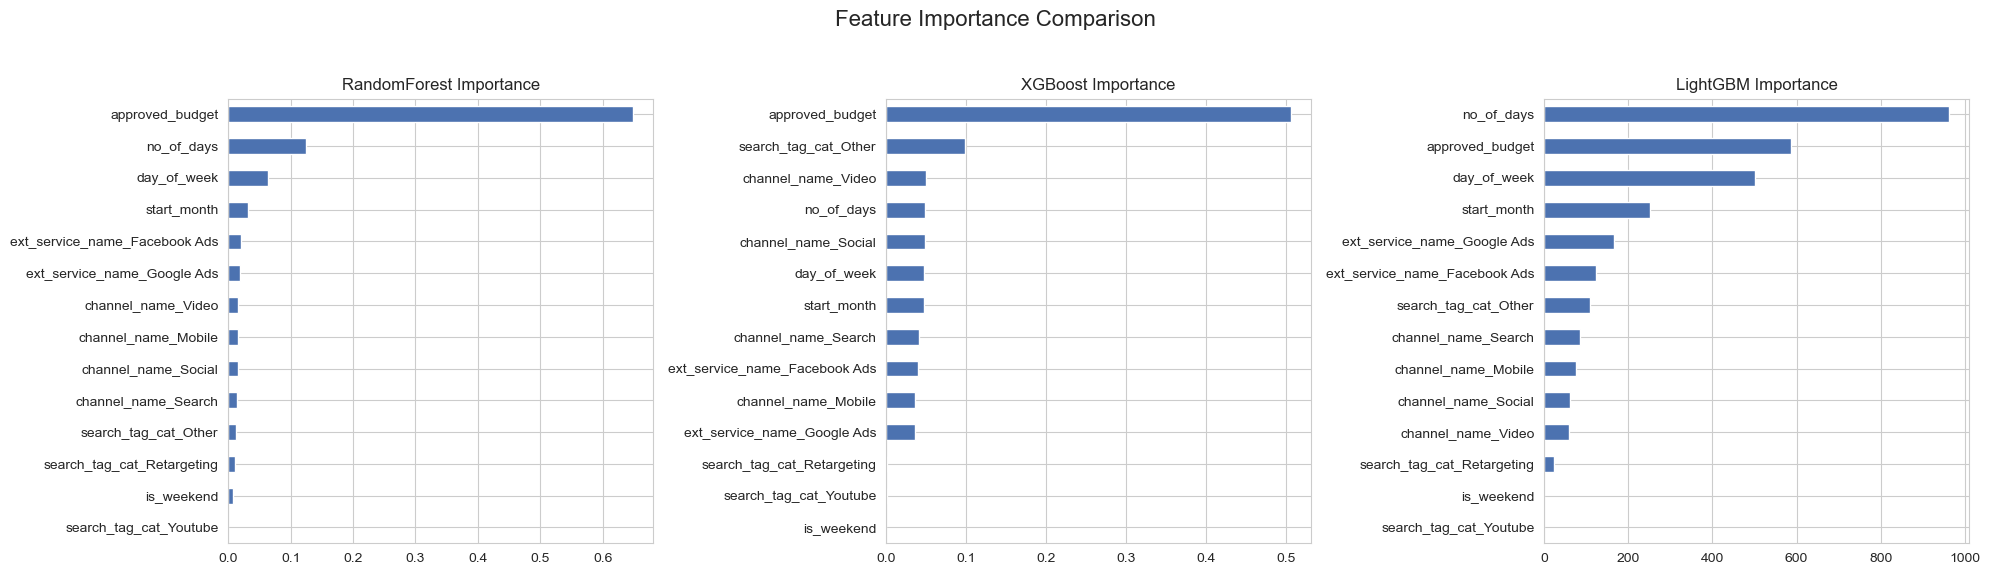

In [18]:
# DEFINE TARGET & LEAKAGE
TARGET = 'overcost'

leakage_cols = [
    TARGET,
    'campaign_item_id',
    'campaign_budget_usd',
    'media_cost_usd',
    'clicks', 'impressions',
    'Unnamed: 0', 'Unnamed__0'
]

# safely find which columns to drop
cols_to_drop = [c for c in leakage_cols if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

print(f"✅ Input Features: {X.shape[1]}")
print(f"🗑️ Dropped Leakage: {cols_to_drop}")

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MULTI-MODEL FEATURE IMPORTANCE VISUALIZATION
print("\n🔍 Training Inspector Models to compare Feature Importance...")

inspectors = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison', fontsize=16)

for i, (name, model) in enumerate(inspectors.items()):
    print(f"   -> Analyzing with {name}...")
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    feat_series = pd.Series(importances, index=X_train.columns)
    
    ax = axes[i]
    feat_series.nlargest(15).plot(kind='barh', ax=ax, color='#4c72b0')
    ax.set_title(f"{name} Importance")
    ax.invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Baseline Model Evaluation

Trains standard models (RandomForest, XGBoost, LightGBM) without optimization to establish a performance baseline. Calculates key metrics R2, RMSE, and Cross-Validation scores to assess initial accuracy.

In [19]:
from sklearn.pipeline import Pipeline

# Define Baseline Models
models = {
    'RandomForest': RandomForestRegressor(random_state=42), 
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

print("\n📊 MARKET ENGINE BASELINE RESULTS")
print("-" * 115)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'RMSE':<12} | {'CV Score':<10}")
print("-" * 115)

for name, model in models.items():
    # Create Pipeline
    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=f_regression, k=10).set_output(transform="pandas")),
        ('regressor', model)
    ])
    
    # Train Pipeline on Full Train Set
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    
    # Calculate Standard Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    gap = r2_train - r2_test
    
    # Calculate Cross-Validation Score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    cv_avg = cv_scores.mean()
    
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | ${rmse:,.0f}    | {cv_avg:.4f}")

print("-" * 115)


📊 MARKET ENGINE BASELINE RESULTS
-------------------------------------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | RMSE         | CV Score  
-------------------------------------------------------------------------------------------------------------------
RandomForest    | 0.5108     | 0.8743     | 0.3634     | $84,325    | 0.5099
XGBoost         | 0.4170     | 0.8621     | 0.4450     | $92,056    | 0.4353
LightGBM        | 0.5717     | 0.7333     | 0.1616     | $78,909    | 0.5701
-------------------------------------------------------------------------------------------------------------------


## 5. Hyperparameter Optimization

Performs Randomized Search Cross-Validation to fine-tune hyperparameters for each model. Evaluates the optimized models on Test data and automatically selects the best performer based on the Test R2 Score.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Configure The Best Model
if 'conversion_rate' in df.columns: 
    print("⚙️ Configuring Advertising Champion: RandomForest (Depth 3, Top 5 Features)...")
    
    champion_selector = f_regression          
    champion_k = 5                            
    champion_model = RandomForestRegressor(
        n_estimators=100,                  
        max_depth=3,
        random_state=42
    )
    best_model_name = "RandomForest_Depth3_Top5"

else:
    print("⚙️ Configuring Marketing Champion: LightGBM (Slow Learning, Mutual Info)...")
    
    champion_selector = mutual_info_regression 
    champion_k = 10                            
    champion_model = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.01,
        num_leaves=31, 
        random_state=42, 
        verbose=-1
    )
    best_model_name = "LightGBM_SlowLearn_MutInfo"

# BUILD PIPELINE
best_opt_model = Pipeline([
    ('selector', SelectKBest(score_func=champion_selector, k=champion_k).set_output(transform="pandas")),
    ('regressor', champion_model)
])

# TRAIN
print(f"🔄 Training {best_model_name} on full Training Set...")
best_opt_model.fit(X_train, y_train)

# METRICS
y_pred_test = best_opt_model.predict(X_test)
best_opt_r2 = r2_score(y_test, y_pred_test)
best_opt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"✅ Training Complete.")
print(f"   R2 Score: {best_opt_r2:.4f}")
print(f"   RMSE:     {best_opt_rmse:.5f}")

⚙️ Configuring Marketing Champion: LightGBM (Slow Learning, Mutual Info)...
🔄 Training LightGBM_SlowLearn_MutInfo on full Training Set...
✅ Training Complete.
   R2 Score: 0.6345
   RMSE:     72889.66079


## 6. Feature Importance Visualization

Extracts and visualizes the top 5 most influential features for each model. This step show exactly which data points the models are prioritizing for their predictions.


🔍 Visualizing Logic for: LightGBM_SlowLearn_MutInfo...

✅ Top Features used by LightGBM_SlowLearn_MutInfo:
                      Feature  Importance
                   no_of_days        3968
              approved_budget        2287
                  start_month         912
ext_service_name_Facebook Ads         522
                   is_weekend         469
          channel_name_Mobile         356
         search_tag_cat_Other         292
           channel_name_Video         194
   search_tag_cat_Retargeting           0
       search_tag_cat_Youtube           0


C:\Users\gonal\AppData\Local\Temp\ipykernel_38168\3694388310.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_palette)


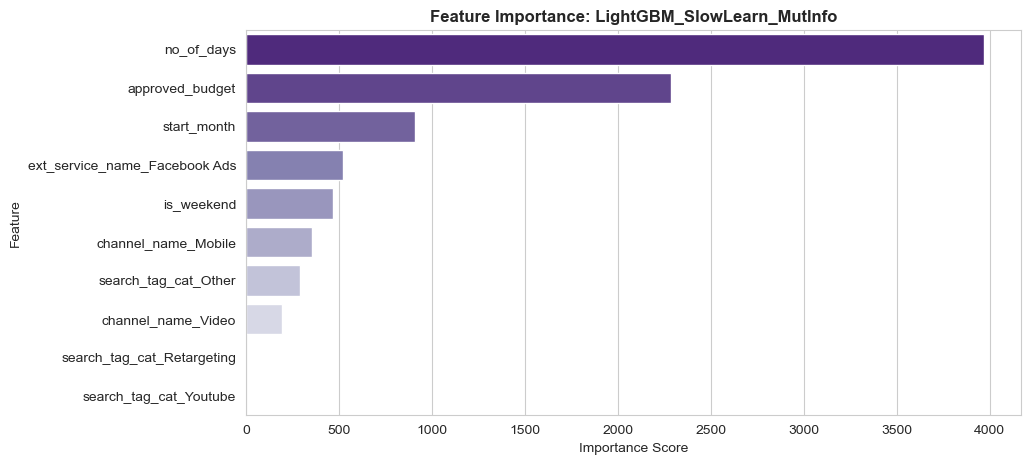

In [21]:
if best_opt_model is not None:
    print(f"\n🔍 Visualizing Logic for: {best_model_name}...")
    
    # Extract parts from pipeline
    selector = best_opt_model.named_steps['selector']
    regressor = best_opt_model.named_steps['regressor']
    
    # Get Feature Names
    selected_mask = selector.get_support()
    selected_features = X_train.columns[selected_mask]
    
    # Extract Importance
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        
        # Create DataFrame
        feat_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Print
        print(f"\n✅ Top Features used by {best_model_name}:")
        print(feat_df.to_string(index=False))
        
        # Plot
        plt.figure(figsize=(10, 5))
        color_palette = 'Blues_r' if 'RandomForest' in best_model_name else 'Purples_r'
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_palette)
        plt.title(f'Feature Importance: {best_model_name}', fontsize=12, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.show()
    else:
        print("⚠️ Model does not support feature importance.")

## 7. Prediction Evaluation

Selects the best performing model and validates its value by comparing it against a "Naive Baseline" (simply guessing the average conversion rate for everyone).

In [22]:
if 'conversion_rate' in df.columns:
    baseline_val = y_train.mean()
    baseline_preds = np.full(len(y_test), baseline_val)
    unit_fmt = "{:.2%}"
    val_fmt = "{:.5f}"
    context = "Average Conversion"
else:
    baseline_val = 0
    baseline_preds = np.zeros(len(y_test)) 
    unit_fmt = "${:,.2f}"
    val_fmt = "${:,.2f}"
    context = "Zero Overcost"

# Calculate Errors
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = best_opt_rmse
improvement = baseline_rmse - model_rmse

# Print Report
print(f"\n📊 BASELINE COMPARISON (The 'Duck Test')")
print("-" * 60)
print(f"1. Baseline Guess ({context}): RMSE = {val_fmt.format(baseline_rmse)}")
print(f"2. Your Champion ({best_model_name}):   RMSE = {val_fmt.format(model_rmse)}")
print("-" * 60)

if improvement > 0:
    print(f"✅ SUCCESS: Your model is {improvement/baseline_rmse:.1%} more accurate than the baseline.")
else:
    print(f"❌ FAIL: The model is worse than just guessing.")


📊 BASELINE COMPARISON (The 'Duck Test')
------------------------------------------------------------
1. Baseline Guess (Zero Overcost): RMSE = $122,468.58
2. Your Champion (LightGBM_SlowLearn_MutInfo):   RMSE = $72,889.66
------------------------------------------------------------
✅ SUCCESS: Your model is 40.5% more accurate than the baseline.


## 8. Save Model

Persists the final, best performing model to a .joblib file. The filename is automatically versioned with the model type, its R2 accuracy score, and a timestamp to ensure reproducibility and easy tracking of experiments.

In [23]:
#show all columns in order
pd.set_option('display.max_columns', None)
print(X.head())

   no_of_days  approved_budget  start_month  day_of_week  is_weekend  \
0           7            400.0            5            6           1   
1           8            400.0            5            0           0   
2           9            400.0            5            1           0   
3          10            400.0            5            2           0   
4          11            400.0            5            3           0   

   ext_service_name_Facebook Ads  ext_service_name_Google Ads  \
0                              1                            0   
1                              0                            0   
2                              1                            0   
3                              1                            0   
4                              0                            1   

   channel_name_Mobile  channel_name_Search  channel_name_Social  \
0                    1                    0                    0   
1                    0                  

In [24]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M")

if 'conversion_rate' in df.columns:
    save_dir = "../Model_Training/Trained_Models/Advertising"
    prefix = "Advertising"
else:
    save_dir = "../Model_Training/Trained_Models/Marketing"
    prefix = "Marketing"

# Create Directory
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Create Specific Filename
filename = f"{prefix}_{best_model_name}_R2-{best_opt_r2:.3f}_{timestamp}.joblib"
save_path = os.path.join(save_dir, filename)

# Save
if best_opt_model is not None:
    joblib.dump(best_opt_model, save_path)
    print(f"💾 FILE SAVED SUCCESSFULLY:")
    print(f"   Path: {save_path}")
else:
    print("❌ Error: No model found to save.")

💾 FILE SAVED SUCCESSFULLY:
   Path: ../Model_Training/Trained_Models/Marketing\Marketing_LightGBM_SlowLearn_MutInfo_R2-0.635_20260118_0305.joblib
